# Importing Modules

The necessary modules are : os, opencv, numpy, tqdm, matplotlib, keras and sklearn

In [201]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers import ELU, LeakyReLU
from tensorflow.keras.utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Constructing Training and Test Datasets

## Loading the Images

We first load all the images and the corresponding segmentation masks. 

They are stored in two lists X, Y and respectively

Moreover, the images are resized to 256x192

In [205]:
# Chemin d'accès aux images et masques
train_images_path = 'plantDoc_leaf_disease/aug_data/train/images'
train_masks_path = 'plantDoc_leaf_disease/aug_data/train/masks'
test_images_path = 'plantDoc_leaf_disease/aug_data/test/images'
test_masks_path = 'plantDoc_leaf_disease/aug_data/test/masks'

# Chargement des noms de fichiers
train_img_files = next(os.walk(train_images_path))[2]
train_msk_files = next(os.walk(train_masks_path))[2]
test_img_files = next(os.walk(test_images_path))[2]
test_msk_files = next(os.walk(test_masks_path))[2]

# Tri des fichiers
train_img_files.sort()
train_msk_files.sort()
test_img_files.sort()
test_msk_files.sort()

# Initialisation des listes
X_train = []
Y_train = []
X_test = []
Y_test = []

# Chargement des images de test
for img_fl in tqdm(test_img_files):
    if img_fl.split('.')[-1] == 'jpg':
        img = cv2.imread(os.path.join(test_images_path, img_fl), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img, (256, 192), interpolation=cv2.INTER_CUBIC)
        X_test.append(resized_img)

        msk = cv2.imread(os.path.join(test_masks_path, img_fl.split('.')[0] + '.png'), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk, (256, 192), interpolation=cv2.INTER_CUBIC)
        Y_test.append(resized_msk)

# Chargement des images de train
for img_fl in tqdm(train_img_files):
    if img_fl.split('.')[-1] == 'jpg':
        img = cv2.imread(os.path.join(train_images_path, img_fl), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img, (256, 192), interpolation=cv2.INTER_CUBIC)
        X_train.append(resized_img)

        msk = cv2.imread(os.path.join(train_masks_path, img_fl.split('.')[0] + '.png'), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk, (256, 192), interpolation=cv2.INTER_CUBIC)
        Y_train.append(resized_msk)


print(f"=> train_img_files = {train_img_files}")
print(f"=> train_msk_files = {train_msk_files}")
print(f"=> test_img_files = {test_img_files}")
print(f"=> test_msk_files = {test_msk_files}")

# plt.show(plt.imshow(X_train[0]))
# plt.show(plt.imshow(Y_train[0]))
# plt.show(plt.imshow(cv2.cvtColor(X_test[8], cv2.COLOR_BGR2RGB)))
# plt.show(plt.imshow(cv2.cvtColor(Y_test[8], cv2.COLOR_GRAY2RGB)))
# plt.show(plt.imshow(cv2.cvtColor(X_train[28], cv2.COLOR_BGR2RGB)))
# plt.show(plt.imshow(cv2.cvtColor(Y_train[28], cv2.COLOR_GRAY2RGB)))
# plt.show(plt.imshow(cv2.cvtColor(X_test[13], cv2.COLOR_BGR2RGB)))
# plt.show(plt.imshow(cv2.cvtColor(Y_test[13], cv2.COLOR_GRAY2RGB)))


100%|██████████| 470/470 [00:04<00:00, 94.83it/s] 

=> train_img_files = ['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00023.jpg', '00024.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00042.jpg', '00044.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00054.jpg', '00056.jpg', '00057.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00075.jpg', '00076.jpg', '00078.jpg', '00079.jpg', '00080.jpg', '00081.jpg', '00082.jpg', '00083.jpg', '00084.jpg', '00085.jpg', '00086.jpg', '00088.jpg', '00089.jpg', '00090.jpg', '00091.jpg', '00

## Train-Test Split

The X, Y lists are converted to numpy arrays for convenience. 
Furthermore, the images are divided by 255 to bring down the pixel values to [0...1] range. On the other hand the segmentations masks are converted to binary (0 or 1) values.

Using Sklearn *train_test_split* we split the data randomly into 80% training and 20% testing data

len(X_train) = 470
len(X_test) = 118
len(Y_train) = 470
len(Y_test) = 118
APRES NORMALISATION (/255)


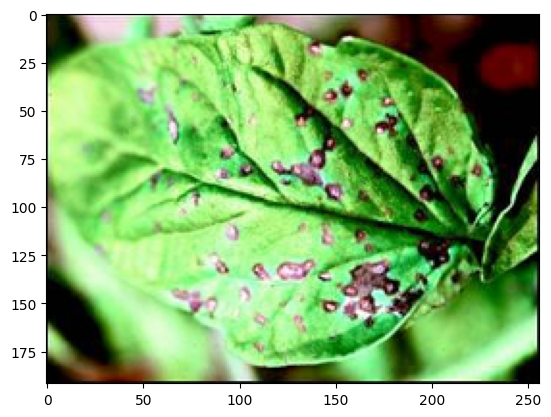

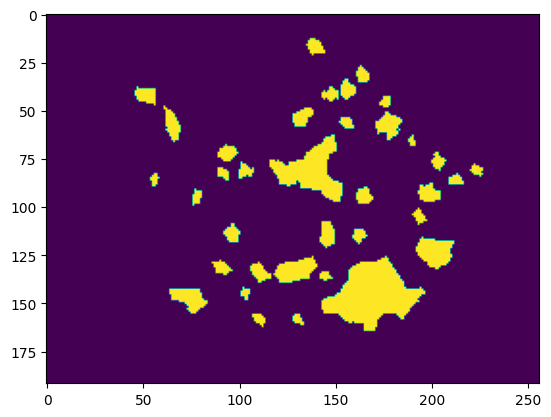

X_train shape: (470, 192, 256, 3)
Y_train shape: (470, 192, 256, 1)
X_test shape: (118, 192, 256, 3)
Y_test shape: (118, 192, 256, 1)


In [206]:
print(f"len(X_train) = {len(X_train)}")
print(f"len(X_test) = {len(X_test)}")
print(f"len(Y_train) = {len(Y_train)}")
print(f"len(Y_test) = {len(Y_test)}")

# Conversion en tableaux numpy
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Ajustement des dimensions
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], 1))


# Normalisation des valeurs de pixel
X_train = X_train / 255.0
X_test = X_test / 255.0
Y_train = Y_train / 255.0
Y_test = Y_test / 255.0

# plt.show(plt.imshow(X_train[0]))
# plt.show(plt.imshow(Y_train[0]))
# print("X_train",X_train[0])
# print("Y_train",Y_train[0])


# # Arrondir les valeurs de masque à 0 ou 1
# Y_train = np.round(Y_train, 0)
# Y_test = np.round(Y_test, 0)


# Seuil pour binariser les masques
threshold = 0

# Binarisation des masques
Y_train = (Y_train > threshold).astype(np.float32)
Y_test = (Y_test > threshold).astype(np.float32)


# print("APRES NORMALISATION (/255)")
# plt.show(plt.imshow(X_train[0]))
# plt.show(plt.imshow(Y_train[0]))

# print("min, max", np.min(Y_train), np.max(Y_train))

# Affichage des dimensions
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


# MultiResUNet Model

## Model Definition

The MultiResUNet model as described in the [paper](https://arxiv.org/abs/1902.04049) can be found  [here](https://github.com/nibtehaz/MultiResUNet/blob/master/MultiResUNet.py)

In [207]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model


## Auxiliary Functions

### Custom Metrics

Since Keras does not have build-in support for computing Dice Coefficient or Jaccard Index (at the time of writing), the following functions are declared

In [208]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

### Saving Model 

Function to save the model

In [209]:
def saveModel(model):

    model_json = model.to_json()

    try:
        os.makedirs('models')
    except:
        pass
    
    fp = open('models/modelP.json','w')
    fp.write(model_json)
    model.save_weights('models/modelW.h5')


### Evaluate the Model

We evaluate the model on test data (X_test, Y_test). 

We compute the values of Jaccard Index and Dice Coeficient, and save the predicted segmentation of first 10 images. The best model is also saved

(This could have been done using keras call-backs as well)

In [210]:
def evaluateModel(model, X_test, Y_test, batchSize):
    
    try:
        os.makedirs('results')
    except:
        pass 
    

    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)
    
    yp = np.round(yp,0)

    for i in range(len(X_test)):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(X_test[i])
        plt.title('Input')
        plt.subplot(1,3,2)
        plt.imshow(Y_test[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        if np.sum(union) == 0:
            jacard = 0
        else:
            jacard = (np.sum(intersection)/np.sum(union))  
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig('results/aug_data/'+str(i)+'.png',format='png')
        plt.close()

    jacard = 0
    dice = 0
    
    
    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        if np.sum(union) == 0:
            jacard += 0
        else:
            jacard += (np.sum(intersection) / np.sum(union))

        if (np.sum(yp_2) + np.sum(y2)) == 0:
            dice += 0
        else:
            dice += (2. * np.sum(intersection)) / (np.sum(yp_2) + np.sum(y2))

    
    jacard /= len(Y_test)
    dice /= len(Y_test)
    
    
    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    

    fp = open('models/log.txt','a')
    fp.write(str(jacard)+'\n')
    fp.close()

    fp = open('models/best.txt','r')
    best = fp.read()
    fp.close()

    if(jacard>float(best)):
        print('***********************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('***********************************************')
        fp = open('models/best.txt','w')
        fp.write(str(jacard))
        fp.close()

        saveModel(model)


### Training the Model

The model is trained and evaluated after each epochs

In [211]:
def trainStep(model, X_train, Y_train, X_test, Y_test, epochs, batchSize):

    
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=1, verbose=1)     

        evaluateModel(model,X_test, Y_test,batchSize)

    return model 

## Define Model, Train and Evaluate

In [212]:
model = MultiResUnet(height=192, width=256, n_channels=3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])

saveModel(model)

fp = open('models/log.txt','w')
fp.close()
fp = open('models/best.txt','w')
fp.write('-1.0')
fp.close()
    
trainStep(model, X_train, Y_train, X_test, Y_test, epochs=10, batchSize=10)

Epoch : 1
12/12 [==============================] - 14s 1s/step
Jacard Index : 0.25067424317979714
Dice Coefficient : 0.37220318348945125
***********************************************
Jacard Index improved from -1.0 to 0.25067424317979714
***********************************************
Epoch : 2
12/12 [==============================] - 13s 1s/step
Jacard Index : 0.22766587688287687
Dice Coefficient : 0.3451003462941449
Epoch : 3
12/12 [==============================] - 13s 1s/step
Jacard Index : 0.18066325556423704
Dice Coefficient : 0.2867186438073766
Epoch : 4
12/12 [==============================] - 13s 1s/step
Jacard Index : 0.25172694751467967
Dice Coefficient : 0.3528184823311405
***********************************************
Jacard Index improved from 0.25067424317979714 to 0.25172694751467967
***********************************************
Epoch : 5
12/12 [==============================] - 13s 1s/step
Jacard Index : 0.35019683346578506
Dice Coefficient : 0.48394604772267774
*